## Rank ChEMBL antivirals and all drugs using cosine similarity to SARS-CoV-2

In this notebook, we rank ChEMBL antiviral drugs and other sets of drugs for their suitability for COVID-19 repurposing using their cosine similarity to SARS-CoV-2 in latent space, using our KG embeddings.

####  Some variables

In [125]:
import os

base_dl_dir = "downloaded_data"
graph_data_dir = os.path.join(base_dl_dir, "kg-covid-19-20201012")
embedding_data_dir = os.path.join(base_dl_dir, "embeddings-20201012")

# graph stuff
graph_out_file = os.path.join(graph_data_dir + "/kg-covid-19.tar.gz")
nodes_file = os.path.join(graph_data_dir, "merged-kg_nodes.tsv")
edges_file = os.path.join(graph_data_dir, "merged-kg_edges.tsv")
sorted_edges_file = os.path.join(graph_data_dir, "merged-kg_edges_SORTED.tsv")
graph_tar_url = "https://kg-hub.berkeleybop.io/kg-covid-19/20201012/kg-covid-19.tar.gz"

# embeddings URLs
base_kghub_url = "http://kg-hub.berkeleybop.io/"
embeddings_url = os.path.join(base_kghub_url, "embeddings/20201012/SkipGram/reduced_graph.csv.gz")
embedding_file = os.path.join(embedding_data_dir, "SkipGram/reduced_graph.csv.gz")

# outfiles
chembl_antiviral_ranked_dir = os.path.join(base_dl_dir, "ranked-drug-lists", "cosine_sim")
os.makedirs(chembl_antiviral_ranked_dir, exist_ok=True)
chembl_antiviral_ranked_outfile = os.path.join(chembl_antiviral_ranked_dir, "chembl_antiviral_cosine_sim.tsv")
drugs_ranked_outfile = os.path.join(chembl_antiviral_ranked_dir, "drug_cosine_sim")
top_x = 30 # also output file for top X ranks

In [4]:
chembl_prefix = 'CHEMBL.COMPOUND'
chembl_nodes_url = "https://kg-hub.berkeleybop.io/kg-covid-19/20201012/transformed/ChEMBL/nodes.tsv"
chembl_nodes_file = os.path.join(chembl_antiviral_dir, "nodes.tsv")
chembl_antiviral_file = os.path.join(chembl_antiviral_dir, "sars_cov_2_compounds.txt")

In [5]:
sars_cov_2_gpi_dir = os.path.join(base_dl_dir, "sars-cov-2-gpi")
sars_cov_2_gpi_file = os.path.join(sars_cov_2_gpi_dir, "uniprot_sars-cov-2.gpi")
sars_cov_2_gpi_url = "https://raw.githubusercontent.com/Knowledge-Graph-Hub/kg-covid-19/master/curated/ORFs/uniprot_sars-cov-2.gpi"

In [6]:
sars_cov_2_curie = 'NCBITaxon:2697049'

In [7]:
from pkg_resources import get_distribution
assert(get_distribution("ensmallen-graph").version == '0.4.4')
assert(get_distribution("embiggen").version == '0.6.0')

#### Download the graph if necessary

In [8]:
import urllib
import os
os.makedirs(graph_data_dir, exist_ok=True)

if not os.path.exists(nodes_file) or not os.path.exists(edges_file):
    with urllib.request.urlopen(graph_tar_url) as response, \
        open(graph_out_file, 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)
    os.system("tar -xvzf " + graph_out_file + " -C " + graph_data_dir)

#### Download embeddings if necessary

In [9]:
os.makedirs(embedding_data_dir, exist_ok=True)

if not os.path.exists(embedding_file):
    with urllib.request.urlopen(embeddings_url) as response, \
        open(embedding_file, 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)

#### Make a graph with chembl holdout edges labeled

In [10]:
import pandas as pd
import os

new_edge_file = os.path.join(graph_data_dir, 'edges_with_holdout_column.tsv')

if not os.path.exists(new_edge_file): 
    edges = pd.read_csv(
        graph_data_dir + "/merged-kg_edges.tsv",
        sep="\t",
        usecols=[1,3],
        dtype={'subject': str, 'object': str}
    )
    
    pos_node_curies_set = set(positive_nodes.curie)

    chembl_to_sars_cov_2_edges = (
        (edges.subject.str.contains(chembl_prefix) & (edges.object.isin(pos_node_curies_set))) | 
        (edges.object.str.contains(chembl_prefix) & (edges.subject.isin(pos_node_curies_set)))
    )

    edges['holdout_edge_label'] = [
        'chembl_to_sars_cov_2' if value else 'normal'
        for value in chembl_to_sars_cov_2_edges]


    edges.to_csv(new_edge_file, sep="\t", index=False)

In [11]:
%%time
from ensmallen_graph import EnsmallenGraph
graph = EnsmallenGraph.from_unsorted_csv(
    name="kg-covid-19",
    edge_path = new_edge_file,
    sources_column="subject",
    destinations_column="object",
    edge_types_column='holdout_edge_label',
    directed=False,
    node_path = graph_data_dir + "/merged-kg_nodes.tsv",
    nodes_column = 'id',
    node_types_column = 'category',
    default_node_type = 'biolink:NamedThing'
)

CPU times: user 1min 3s, sys: 6.32 s, total: 1min 9s
Wall time: 1min


In [12]:
%%time
reduced_graph = graph.remove_components(edge_types=['chembl_to_sars_cov_2'])
reduced_graph = reduced_graph.remove(singletons=True)

CPU times: user 1min 32s, sys: 2.23 s, total: 1min 34s
Wall time: 1min 38s


#### Load the embeddings

In [13]:
import pandas as pd
embeddings = pd.read_csv(embedding_file, index_col=0)

#### Load curies and names for nodes

In [15]:
import numpy as np
node_curies = list(np.array(reduced_graph.get_node_names()))

In [16]:
node_names = []

node_curie_name_mapping = {}
with open(nodes_file, 'r') as n:
    header = n.readline().split("\t")
    lines = n.readlines()
    for line in lines:
        fields = line.split("\t")
        node_curie_name_mapping[fields[header.index("id")]] = fields[header.index("name")]

for i, this_curie in enumerate(node_curies):
    node_names.append(node_curie_name_mapping[this_curie] if this_curie in node_curie_name_mapping else '')

In [17]:
assert len(node_curies) == len(node_names)
assert len(node_curies) == len(embeddings)

#### Get graph node representating SARS-CoV-2

In [18]:
sars_cov_2_idx = node_curies.index(sars_cov_2_curie)
sars_cov_2_node = {
    'name': 'SARS-CoV-2',
    'curie': sars_cov_2_curie,
    'node_id': node_curies.index(sars_cov_2_curie)
    }

#### method to compute matrix of cosine similarities

In [47]:
from tqdm.auto import tqdm
from scipy import spatial

def get_cosine_sim(x: list, y: list, embeddings: np.ndarray, graph: EnsmallenGraph) ->  np.ndarray:
    cosine_sim = np.full((len(x), len(y)), -1000.0000)

    # precompute node idx to speed things up
    x_node_idx = [graph.get_node_id(node_name) for node_name in tqdm(x, "preloading x node indexes")]
    y_node_idx = [graph.get_node_id(node_name) for node_name in tqdm(y, "preloading y node indexes")]

    for i, row_curie in tqdm(enumerate(x), "computing cosine sim", leave=False):
        for j, col_curie in enumerate(y):
            row_emb = embeddings[x_node_idx[i]]
            col_emb = embeddings[y_node_idx[j]]
            cosine_sim[i,j] = 1 - spatial.distance.cosine(row_emb, col_emb).flatten()[0]

    return cosine_sim

### Rank ChEMBL antivirals by cosine similarity to SARS-CoV-2

In [20]:
if not os.path.exists(os.path.join(chembl_nodes_file)):
    os.makedirs(chembl_antiviral_dir, exist_ok=True)
    with urllib.request.urlopen(chembl_nodes_url) as response, \
        open(chembl_nodes_file, 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)

In [21]:
import re

chembl_antiviral_curies = []
chembl_antiviral_names = []
chembl_antiviral_smile = []

with open(chembl_nodes_file, 'r') as f:
    header = f.readline().split("\t")
    lines = f.readlines()
    for line in lines:
        items = line.split("\t")
        this_id = items[header.index("id")]
        this_name = items[header.index("name")]
        this_smile = items[header.index("canonical_smiles")]
        if re.match(chembl_prefix, this_id):
            chembl_antiviral_curies.append(this_id)
            chembl_antiviral_names.append(this_name)
            chembl_antiviral_smile.append(this_smile)

In [48]:
chembl_antiviral_cosine_sim = get_cosine_sim(
    chembl_antiviral_curies,
    [sars_cov_2_node['curie']],
    embeddings.to_numpy(),
    reduced_graph
)

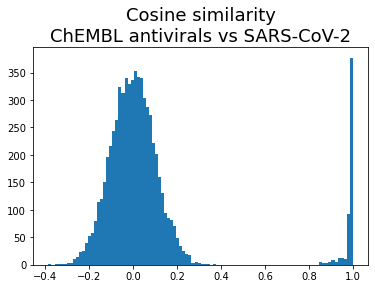

In [41]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(chembl_antiviral_cosine_sim, bins=100)
plt.title("Cosine similarity\nChEMBL antivirals vs SARS-CoV-2", fontsize=18)
plt.show()

In [66]:
chembl_antivirals_ranked = [[z,y,x] for x,y,z in sorted(
    zip(
        chembl_antiviral_cosine_sim.flatten(),
        chembl_antiviral_curies,
        chembl_antiviral_names
        ),
    key=lambda pair: pair[0], reverse=True)]

In [126]:
import re
chembl_antivirals_ranked_pd = pd.DataFrame.from_records(chembl_antivirals_ranked, columns=["drug", "curie", "cosine sim"])
chembl_antivirals_ranked_pd.to_csv(chembl_antiviral_ranked_outfile, sep="\t", index=False)
chembl_antivirals_ranked_pd[0:top_x].to_csv(
    re.sub(".tsv", f"_top{top_x}.tsv", chembl_antiviral_ranked_outfile), sep="\t", index=False)
chembl_antivirals_ranked_pd[0:top_x]

,drug,curie,cosine sim
0,BENZYLPENICILLIN,CHEMBL.COMPOUND:CHEMBL29,0.998231
1,LOPINAVIR,CHEMBL.COMPOUND:CHEMBL729,0.998120
2,RIBAVIRIN,CHEMBL.COMPOUND:CHEMBL1643,0.998042
3,PENTOBARBITAL,CHEMBL.COMPOUND:CHEMBL448,0.997835
4,CYCLOSPORINE,CHEMBL.COMPOUND:CHEMBL160,0.997831
5,HYDROXYCHLOROQUINE,CHEMBL.COMPOUND:CHEMBL1535,0.997778
6,CLINDAMYCIN,CHEMBL.COMPOUND:CHEMBL1753,0.997774
7,ASPIRIN,CHEMBL.COMPOUND:CHEMBL25,0.997564
8,REMDESIVIR,CHEMBL.COMPOUND:CHEMBL4065616,0.997490
9,CIPROFLOXACIN,CHEMBL.COMPOUND:CHEMBL8,0.997440


### Rank all drugs by cosine sim to SARS-CoV-2

In [29]:
assert len(reduced_graph.get_node_types()) == len(embeddings)

In [43]:
drug_idx = list(np.where(reduced_graph.get_node_types() == reduced_graph.get_node_type_names().index('biolink:Drug'))[0])
drug_curies = [node_curies[i] for i in drug_idx]
drug_cosine_sim = get_cosine_sim(
    drug_curies,
    [sars_cov_2_node['curie']],
    embeddings.to_numpy(),
    reduced_graph
    )
drug_names = [node_names[i] for i in drug_idx]

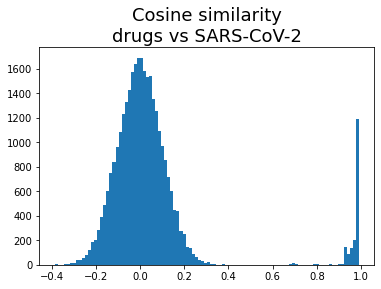

In [86]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(drug_cosine_sim, bins=100)
plt.title("Cosine similarity\ndrugs vs SARS-CoV-2", fontsize=18)
plt.show()

In [71]:
drugs_ranked = [[z,y,x] for x,y,z in sorted(
    zip(
        drug_cosine_sim.flatten(),
        drug_curies,
        drug_names
        ),
      key=lambda pair: pair[0], reverse=True)]

### write out ranked drug lists

In [127]:
import re
drugs_ranked_pd = pd.DataFrame.from_records(drugs_ranked, columns=["drug", "curie", "cosine sim"])
drugs_ranked_pd.to_csv(drugs_ranked_outfile, sep="\t", index=False)
drugs_ranked_pd[0:top_x].to_csv(re.sub(".tsv", f"_top{top_x}.tsv", drugs_ranked_outfile), sep="\t", index=False)
drugs_ranked_pd[0:top_x]

,drug,curie,cosine sim
0,eptinezumab,DrugCentral:5386,0.990896
1,fremanezumab,DrugCentral:5315,0.990588
2,"Ace Inhibitors, Plain",PHARMGKB:PA164712308,0.989413
3,primidone,DrugCentral:2267,0.989266
4,ruxolitinib,DrugCentral:4190,0.989254
5,dolasetron,DRUGBANK:DB00757,0.988516
6,erlotinib,DrugCentral:1045,0.988334
7,dexlansoprazole,DrugCentral:4162,0.988295
8,ripasudil,DrugCentral:4938,0.988228
9,Gliotoxin,ttd.drug:D0N1XD,0.987917
